In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [6]:
df = pd.read_excel('candydistributors.xlsx', sheet_name='candydistributor' )
df['count'] = 1
df.columns

Index(['rowid', 'distances', 'customerid', 'orderid', 'orderdate', 'orderyear',
       'ordermonth', 'shipdate', 'shipyear', 'shipmonth', 'deliverytime',
       'countryregion', 'stateprovince', 'postalcode', 'lat', 'lng', 'stateid',
       'statename', 'countyfips', 'countyname', 'latitude', 'longitude',
       'factory', 'productname', 'productid', 'division', 'units', 'unitcost',
       'unitprice', 'cost', 'grossprofit', 'rangeprofit', 'sales', 'rangsales',
       'distancetype', 'shipmode', 'region', 'city', 'populationtype',
       'population', 'count'],
      dtype='object')

In [7]:
# Convertir la colonne 'orderdate' en type datetime
df['orderdate'] = pd.to_datetime(df['orderdate'])

df['year'] = df['orderdate'].dt.year
df['month'] = df['orderdate'].dt.month

df['month_name'] = df['orderdate'].dt.month_name()

df = df.sort_values(by='month', ascending=True)

In [8]:
df['orderyear'] = df['orderyear'].astype(str)
pivot = df.pivot_table(
    values='grossprofit',  
    index='orderyear',     
    columns='factory',     
    aggfunc='mean'         
)
pivot = pivot.round(2)
pivot

factory    Lot's O' Nuts  Secret Factory  Sugar Shack  The Other Factory  \
orderyear                                                                  
2021                9.08           20.90         4.54               0.92   
2022                9.23           15.23         2.98               1.05   
2023                9.43           23.68         3.47               2.16   
2024                9.21           18.56         3.75               1.87   

factory    Wicked Choccy's  
orderyear                   
2021                  8.70  
2022                  8.82  
2023                  8.58  
2024                  8.68

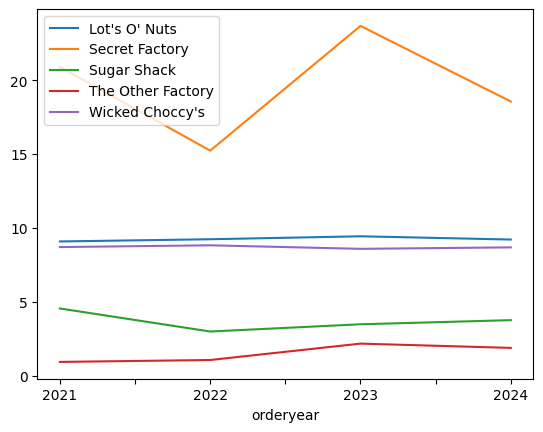

In [9]:
pivot.plot()
plt.legend()

In [10]:
month_order = [
    "January", "February", "March", "April", "May", "June", 
    "July", "August", "September", "October", "November", "December"
]

# Convertir 'month_name' en catégorie avec un ordre spécifique
df['month_name'] = pd.Categorical(df['month_name'], categories=month_order, ordered=True)

df['orderyear'] = df['orderyear'].astype(str)
pivot = df.pivot_table(
    values='count',  
    index='orderyear',     
    columns='month_name',     
    aggfunc='sum'         
)
pivot = pivot.round(2)
pivot

/tmp/ipykernel_15322/255154774.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


month_name  January  February  March  April  May  June  July  August  \
orderyear                                                              
2021             61        40    132    113  118   118   113     131   
2022             54        57    123    126  127   109   110     129   
2023             83        71    153    146  184   171   168     149   
2024            126        95    203    182  215   211   197     183   

month_name  September  October  November  December  
orderyear                                           
2021              234      138       267       253  
2022              245      137       269       278  
2023              317      169       307       305  
2024              381      266       394       391

<Axes: xlabel='month_name'>

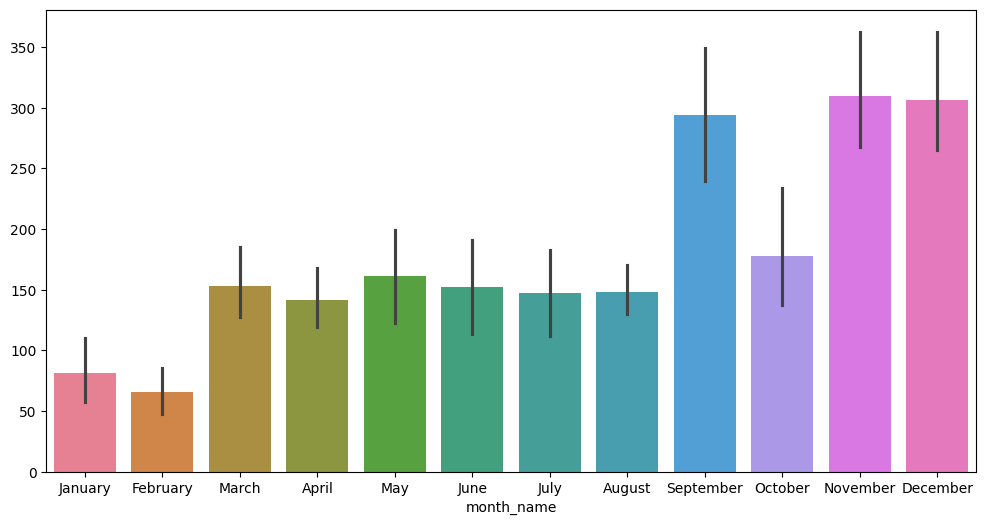

In [11]:
plt.figure(figsize=(12, 6))
sns.barplot(pivot)


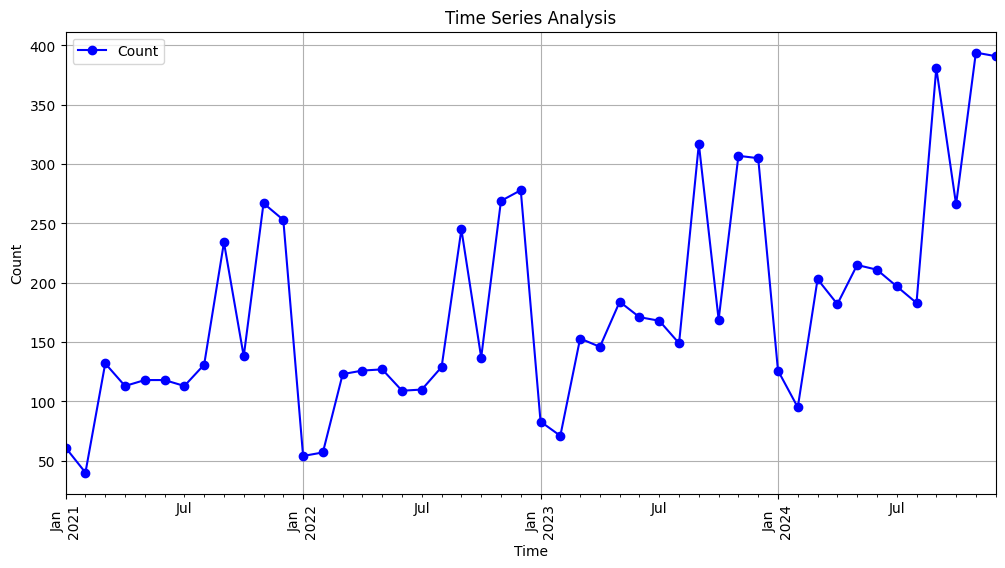

In [12]:

# Réinitialiser l'index pour convertir en un format utilisable pour une série temporelle
pivot.reset_index(inplace=True)

# Fusionner 'orderyear' et 'month_name' pour créer un index temporel
pivot_melted = pivot.melt(id_vars='orderyear', var_name='month_name', value_name='count')
month_order = [
    "January", "February", "March", "April", "May", "June", 
    "July", "August", "September", "October", "November", "December"
]
pivot_melted['month'] = pivot_melted['month_name'].apply(lambda x: month_order.index(x) + 1)
pivot_melted['date'] = pd.to_datetime(pivot_melted['orderyear'] + '-' + pivot_melted['month'].astype(str))

# Trier par date
pivot_melted = pivot_melted.sort_values('date')

# Créer une série temporelle
time_series = pivot_melted.set_index('date')['count']

# Tracer la série temporelle
plt.figure(figsize=(12, 6))
time_series.plot(marker='o', linestyle='-', color='b', label='Count')
plt.title('Time Series Analysis')
plt.ylabel('Count')
plt.xlabel('Time')
plt.grid(True)
plt.legend()
plt.xticks(rotation=90)
plt.show()

/tmp/ipykernel_15322/2930745008.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_data = time_series.resample('Q').mean()


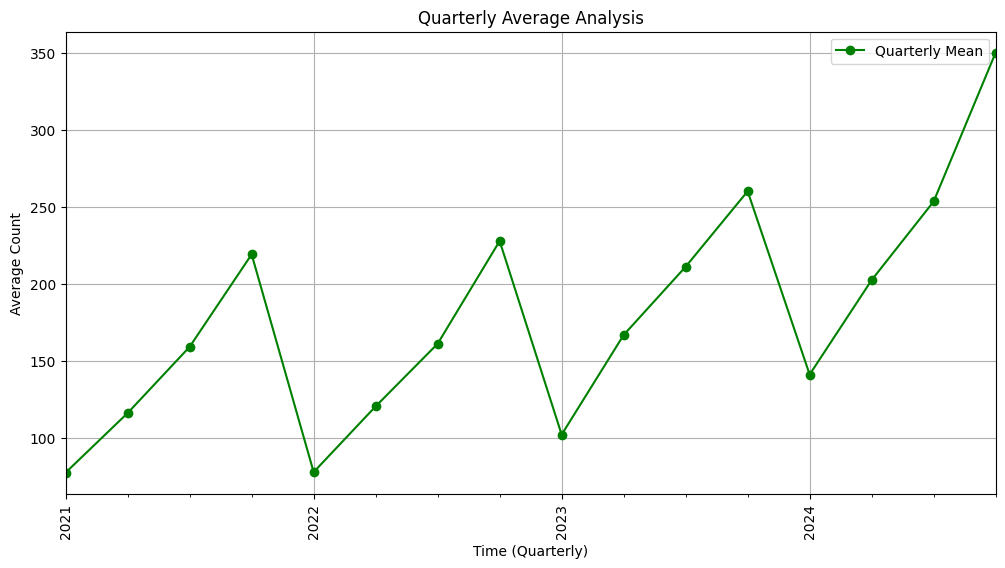

In [13]:
# Grouper par trimestre et calculer la moyenne
quarterly_data = time_series.resample('Q').mean()

# Tracer le graphique
plt.figure(figsize=(12, 6))
quarterly_data.plot(marker='o', linestyle='-', color='g', label='Quarterly Mean')

# Configurer le graphique
plt.title('Quarterly Average Analysis')
plt.ylabel('Average Count')
plt.xlabel('Time (Quarterly)')
plt.grid(True)
plt.legend()

# Afficher toutes les abscisses et les pivoter
plt.xticks(rotation=90)

# Afficher le graphique
plt.show()


/tmp/ipykernel_15322/1178665808.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = filtered_df.pivot_table(
/tmp/ipykernel_15322/1178665808.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = filtered_df.pivot_table(
/tmp/ipykernel_15322/1178665808.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = filtered_df.pivot_table(


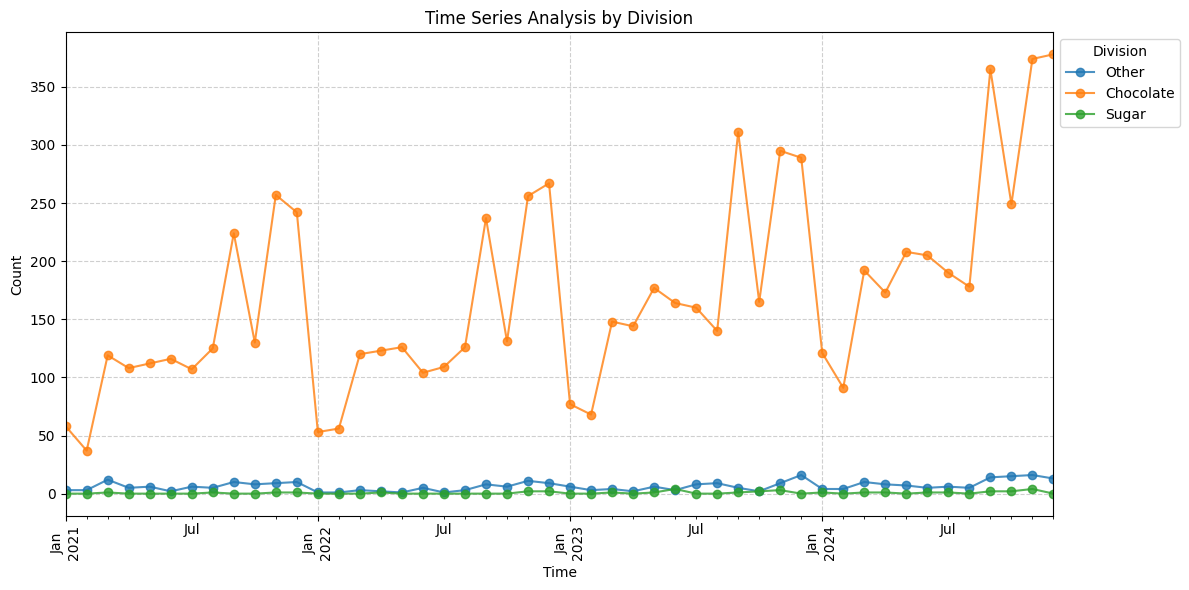

In [14]:
colors = plt.cm.tab10(range(len(df['division'].unique())))

plt.figure(figsize=(12, 6))

# Boucle pour chaque division
for i, division in enumerate(df['division'].unique()):
    # Filtrer les données pour la division actuelle
    filtered_df = df[df['division'] == division]

    # Pivot table
    pivot = filtered_df.pivot_table(
        values='count',  
        index='orderyear',     
        columns='month_name',     
        aggfunc='sum'         
    ).fillna(0)  # Remplacer les valeurs manquantes par 0
    
    # Réinitialiser l'index pour convertir en un format utilisable pour une série temporelle
    pivot.reset_index(inplace=True)

    # Fusionner 'orderyear' et 'month_name' pour créer un index temporel
    pivot_melted = pivot.melt(id_vars='orderyear', var_name='month_name', value_name='count')
    month_order = [
        "January", "February", "March", "April", "May", "June", 
        "July", "August", "September", "October", "November", "December"
    ]
    pivot_melted['month'] = pivot_melted['month_name'].apply(lambda x: month_order.index(x) + 1)
    pivot_melted['date'] = pd.to_datetime(pivot_melted['orderyear'].astype(str) + '-' + pivot_melted['month'].astype(str))

    # Trier par date
    pivot_melted = pivot_melted.sort_values('date')

    # Créer une série temporelle
    time_series = pivot_melted.set_index('date')['count']

    # Tracer la série temporelle
    time_series.plot(
        marker='o', 
        linestyle='-', 
        color=colors[i], 
        label=division, 
        alpha=0.8
    )

# Configurer le graphique
plt.title('Time Series Analysis by Division')
plt.ylabel('Count')
plt.xlabel('Time')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Division', loc='upper left', bbox_to_anchor=(1, 1))  # Légende hors du graphique
plt.xticks(rotation=90)
plt.tight_layout()  # Ajuster les marges pour éviter le chevauchement

# Afficher le graphique
plt.show()


/tmp/ipykernel_15322/202235900.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = filtered_df.pivot_table(
/tmp/ipykernel_15322/202235900.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = filtered_df.pivot_table(


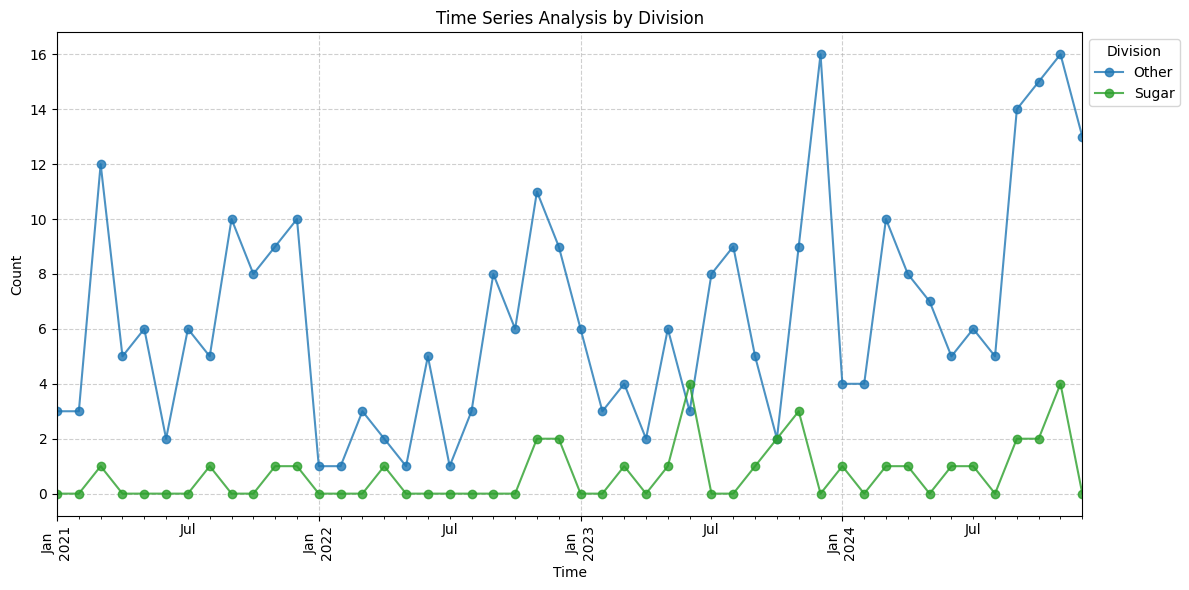

In [43]:
plt.figure(figsize=(12, 6))

# Boucle pour chaque division
for i, division in enumerate(df['division'].unique()) :
    # Filtrer les données pour la division actuelle
    if division=='Chocolate' : continue
    filtered_df = df[df['division'] == division]

    # Pivot table
    pivot = filtered_df.pivot_table(
        values='count',  
        index='orderyear',     
        columns='month_name',     
        aggfunc='sum'         
    ).fillna(0)  # Remplacer les valeurs manquantes par 0
    
    # Réinitialiser l'index pour convertir en un format utilisable pour une série temporelle
    pivot.reset_index(inplace=True)

    # Fusionner 'orderyear' et 'month_name' pour créer un index temporel
    pivot_melted = pivot.melt(id_vars='orderyear', var_name='month_name', value_name='count')
    month_order = [
        "January", "February", "March", "April", "May", "June", 
        "July", "August", "September", "October", "November", "December"
    ]
    pivot_melted['month'] = pivot_melted['month_name'].apply(lambda x: month_order.index(x) + 1)
    pivot_melted['date'] = pd.to_datetime(pivot_melted['orderyear'].astype(str) + '-' + pivot_melted['month'].astype(str))

    # Trier par date
    pivot_melted = pivot_melted.sort_values('date')

    # Créer une série temporelle
    time_series = pivot_melted.set_index('date')['count']

    # Tracer la série temporelle
    time_series.plot(
        marker='o', 
        linestyle='-', 
        color=colors[i], 
        label=division, 
        alpha=0.8
    )

# Configurer le graphique
plt.title('Time Series Analysis by Division')
plt.ylabel('Count')
plt.xlabel('Time')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Division', loc='upper left', bbox_to_anchor=(1, 1))  # Légende hors du graphique
plt.xticks(rotation=90)
plt.tight_layout()  # Ajuster les marges pour éviter le chevauchement

# Afficher le graphique
plt.show()


# Chocolate

In [16]:
chocolate = df[df['division'] =='Chocolate']

<Axes: xlabel='region', ylabel='distances'>

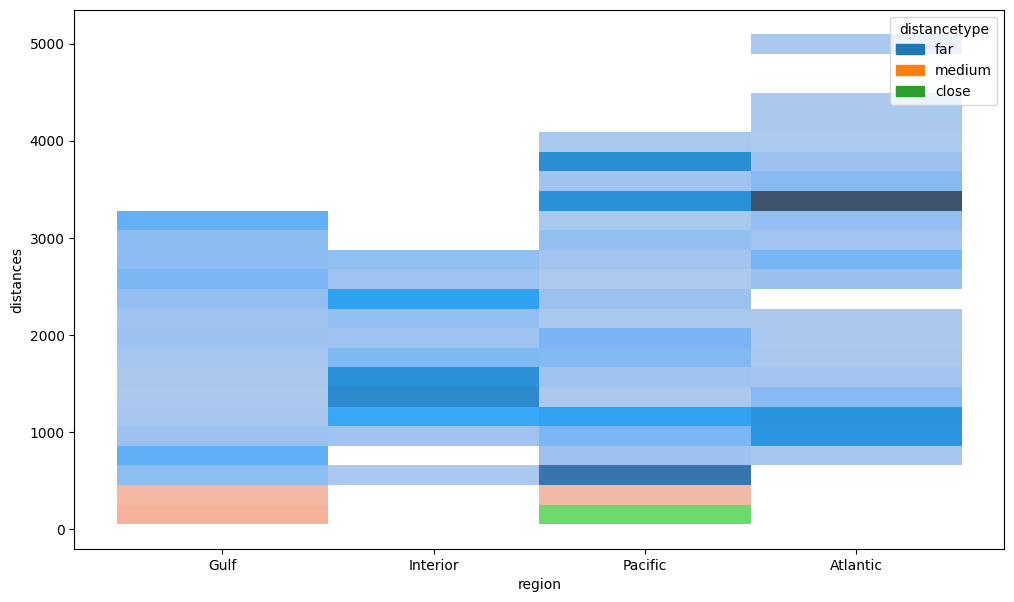

In [42]:
plt.figure(figsize=(12, 7))
sns.histplot(chocolate, x='region' ,  y='distances', hue='distancetype',  shrink=0.6)

<Axes: xlabel='region', ylabel='Count'>

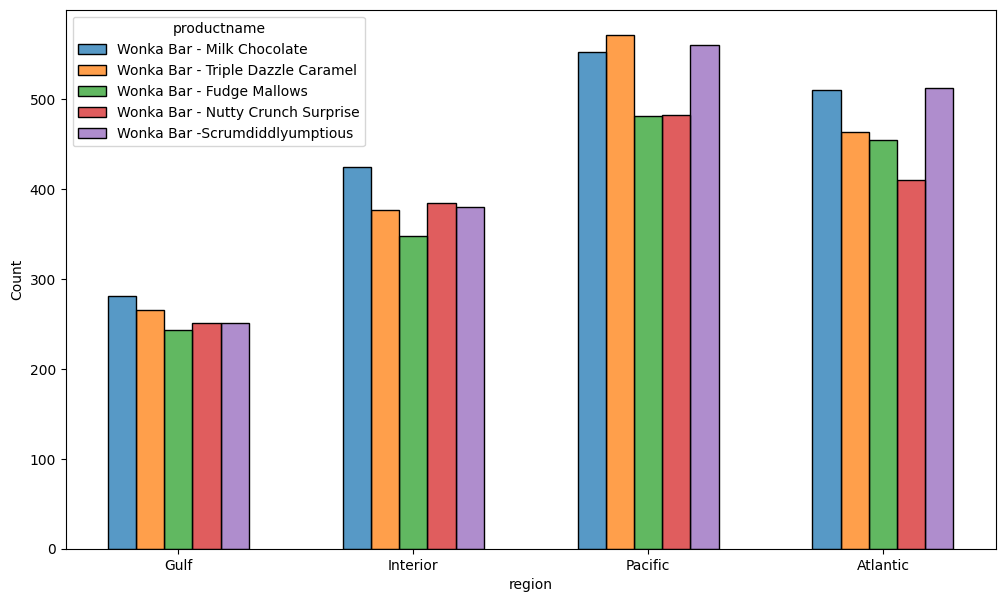

In [17]:
plt.figure(figsize=(12, 7))
sns.histplot(chocolate, x='region' ,  hue='productname', shrink=0.6,  multiple="dodge")

<Axes: xlabel='region', ylabel='grossprofit'>

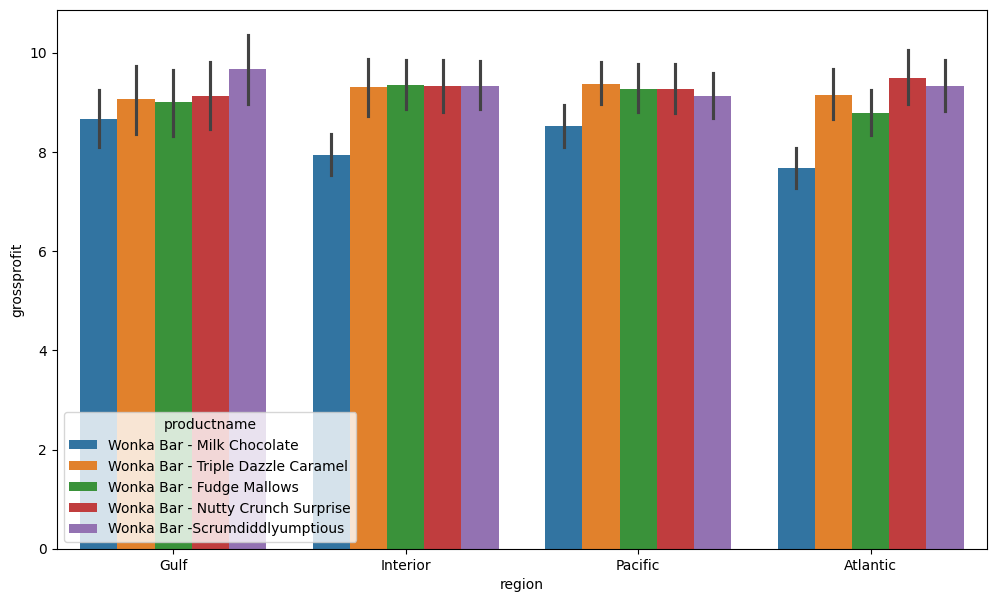

In [41]:
plt.figure(figsize=(12, 7))
sns.barplot(chocolate, x='region' ,y='grossprofit',   hue='productname',)

<Axes: xlabel='region', ylabel='Count'>

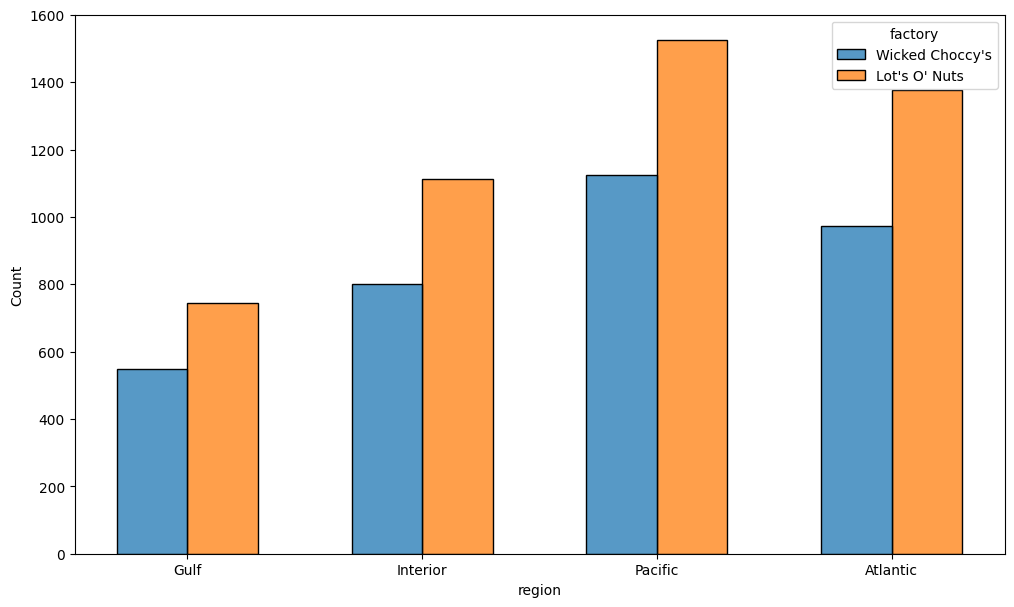

In [19]:
plt.figure(figsize=(12, 7))
sns.histplot(chocolate, x='region' ,  hue='factory', shrink=0.6,  multiple="dodge")

<Axes: xlabel='region', ylabel='grossprofit'>

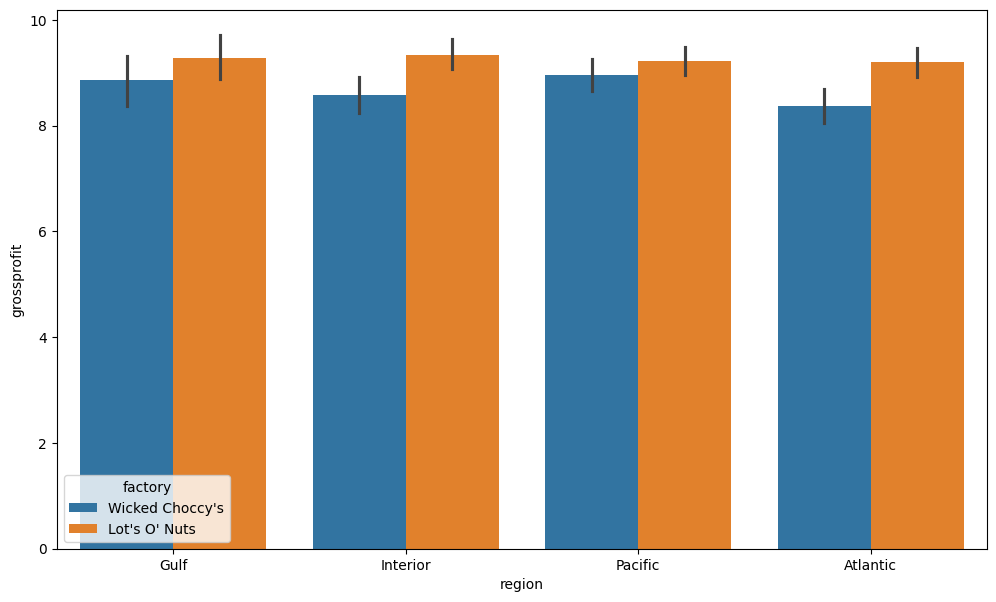

In [40]:
plt.figure(figsize=(12, 7))
sns.barplot(chocolate, x='region' ,y='grossprofit',   hue='factory')

# Sugar

In [20]:
sugar = df[df['division'] =='Sugar']

<Axes: xlabel='region', ylabel='Count'>

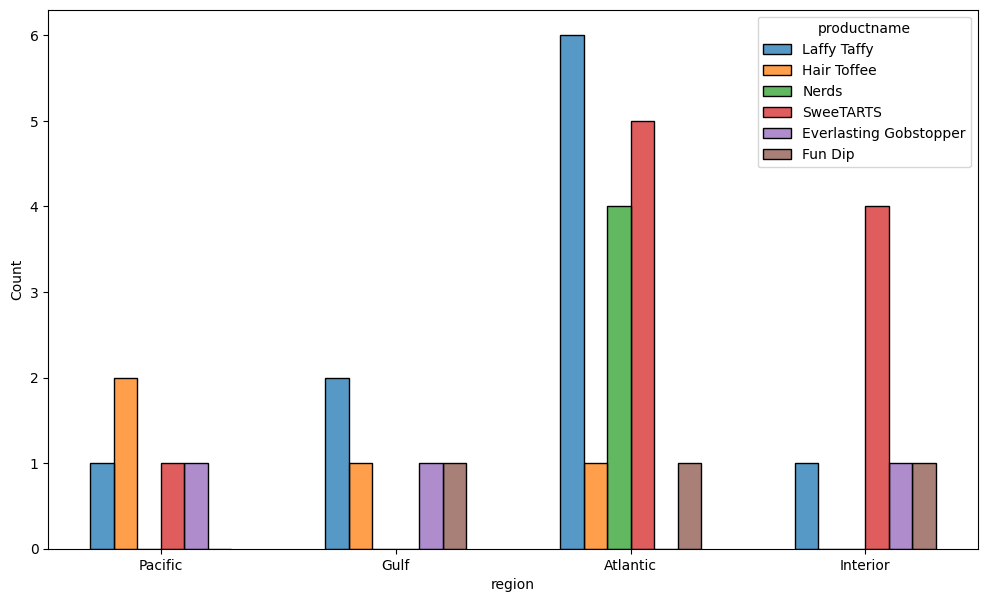

In [21]:
plt.figure(figsize=(12, 7))
sns.histplot(sugar, x='region' ,  hue='productname', shrink=0.6,  multiple="dodge")

<Axes: xlabel='region', ylabel='distances'>

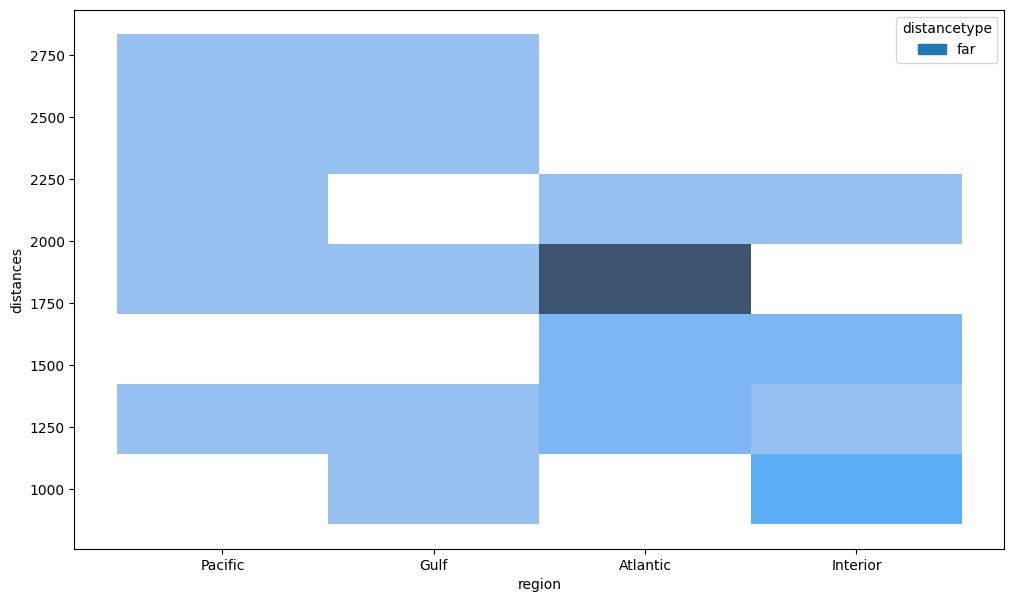

In [22]:
plt.figure(figsize=(12, 7))
sns.histplot(sugar, x='region' ,  y='distances', hue='distancetype',  shrink=0.6)

<Axes: xlabel='region', ylabel='Count'>

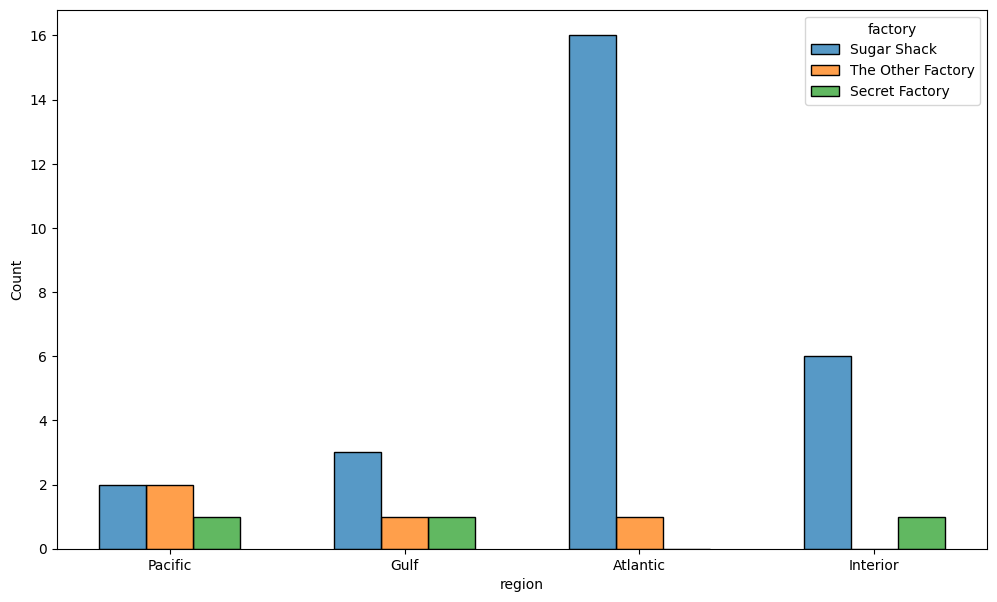

In [23]:
plt.figure(figsize=(12, 7))
sns.histplot(sugar, x='region' ,  hue='factory', shrink=0.6,  multiple="dodge")

<Axes: xlabel='region', ylabel='grossprofit'>

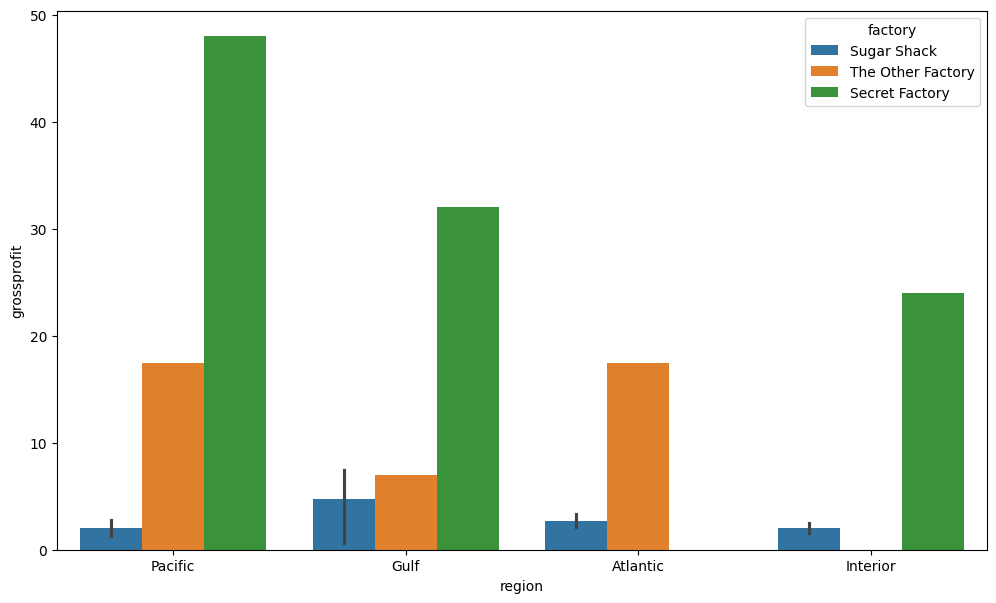

In [39]:
plt.figure(figsize=(12, 7))
sns.barplot(sugar, x='region' ,y='grossprofit',   hue='factory',)

# Other

In [24]:
others = df[df['division'] =='Other']

<Axes: xlabel='region', ylabel='Count'>

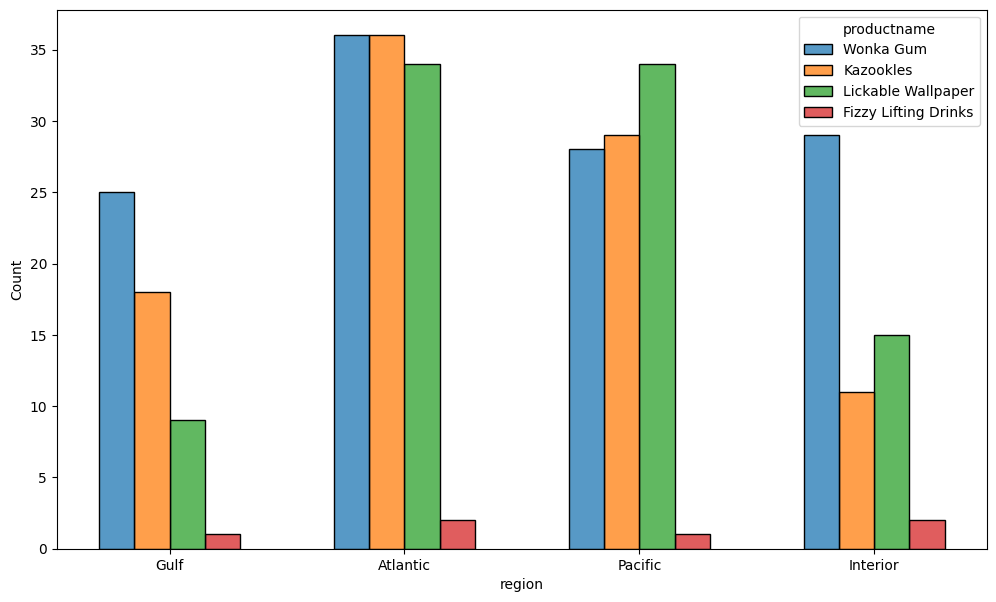

In [25]:
plt.figure(figsize=(12, 7))
sns.histplot(others, x='region' ,  hue='productname', shrink=0.6,  multiple="dodge")

<Axes: xlabel='region', ylabel='Count'>

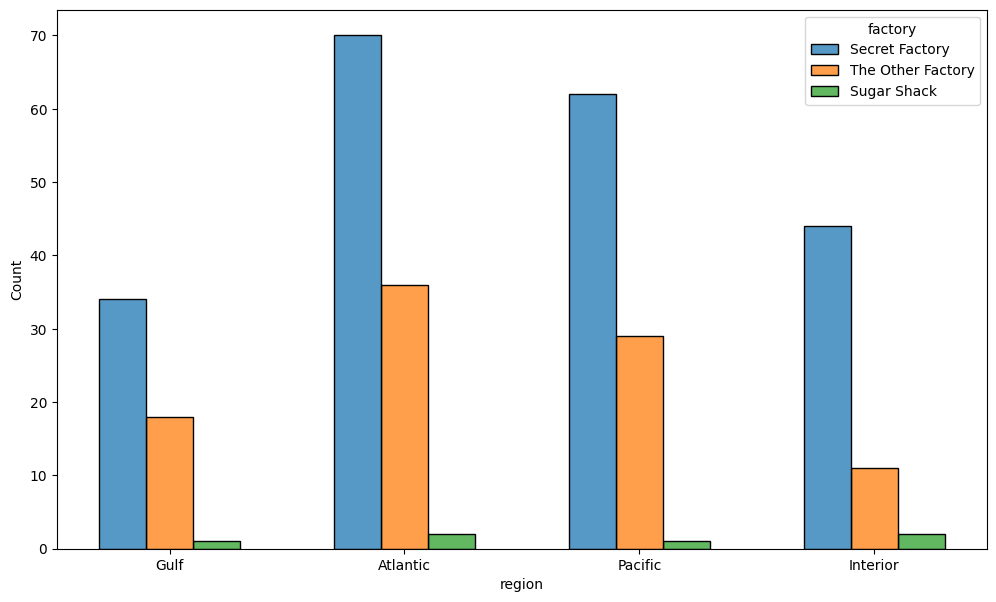

In [26]:
plt.figure(figsize=(12, 7))
sns.histplot(others, x='region' ,  hue='factory', shrink=0.6,  multiple="dodge")

<Axes: xlabel='region', ylabel='grossprofit'>

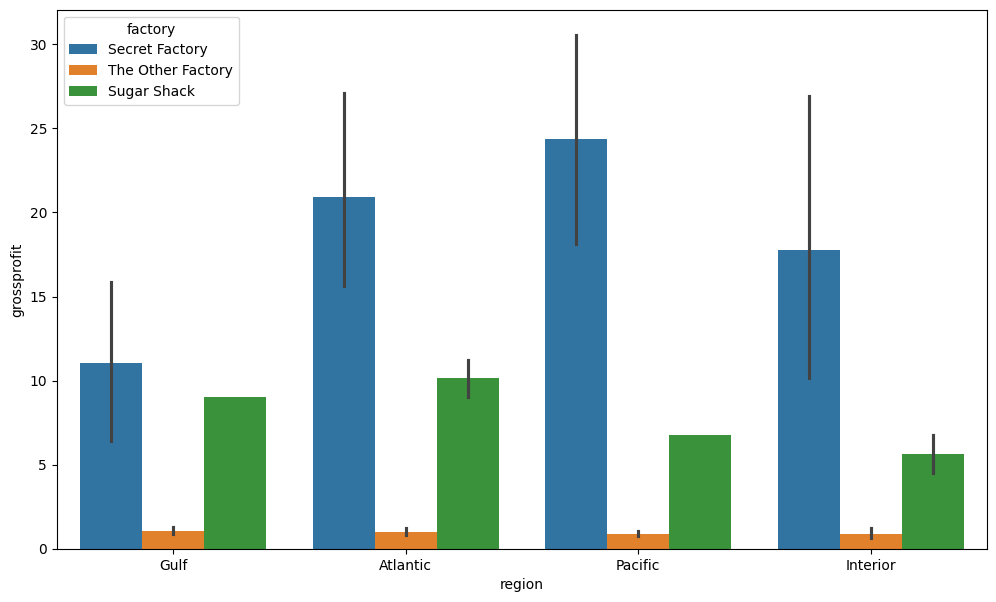

In [38]:
plt.figure(figsize=(12, 7))
sns.barplot(others, x='region' ,y='grossprofit',   hue='factory',)

<Axes: xlabel='region', ylabel='grossprofit'>

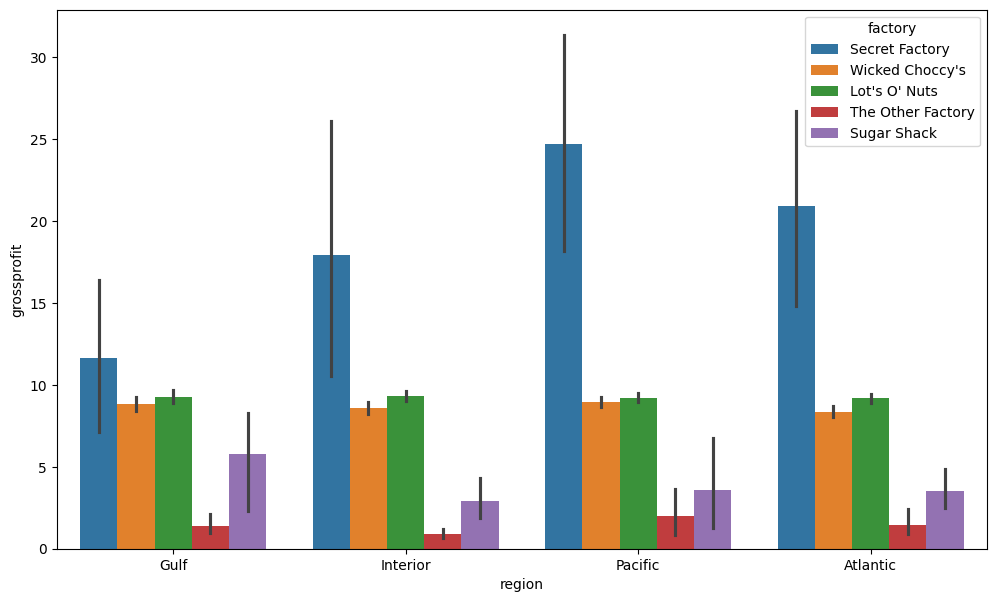

In [ ]:
plt.figure(figsize=(12, 7))
sns.barplot(df, x='region' ,y='grossprofit',   hue='factory',)

In [27]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

In [28]:

# Transformation des données pour l’analyse d’association
transactions = df.groupby('customerid')['productname'].apply(list)

# Encoder les transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

# Générer les itemsets fréquents
frequent_itemsets = apriori(transaction_df, min_support=0.03, use_colnames=True)

print("Itemsets fréquents:")
frequent_itemsets

# Calcul du nombre de transactions (num_itemsets)
num_itemsets = len(transactions)

# Générer les règles d'association
rules = association_rules(frequent_itemsets, num_itemsets=num_itemsets, metric="lift", min_threshold=1)

print("Règles d'association:")
rules.head(4)[['antecedents','consequents','antecedent support','consequent support' ]]

Itemsets fréquents:
Règles d'association:


antecedents  \
0  (Wonka Bar - Milk Chocolate, Wonka Bar - Tripl...   
1  (Wonka Bar - Milk Chocolate, Wonka Bar - Fudge...   
2  (Wonka Bar - Triple Dazzle Caramel, Wonka Bar ...   
3                       (Wonka Bar - Milk Chocolate)   

                                         consequents  antecedent support  \
0                        (Wonka Bar - Fudge Mallows)            0.093577   
1                (Wonka Bar - Triple Dazzle Caramel)            0.091594   
2                       (Wonka Bar - Milk Chocolate)            0.080690   
3  (Wonka Bar - Triple Dazzle Caramel, Wonka Bar ...            0.345956   

   consequent support  
0            0.297383  
1            0.328311  
2            0.345956  
3            0.080690

- Produit tous les produits chocolatés à la fois chez Lot's O' Nuts et Wicked Choccy's.  
- Sur trois années consécutives, "Sugar Shrack" a enregistré un total de 33 commandes. Nous recommandons donc la fermeture de l'usine "Sugar Shrack" ou sa reconversion en une usine de production de chocolat, en mettant l'accent sur les produits chocolatés les plus consommés dans le nord des États-Unis.  
- En ce qui concerne les produits de "Other Factory", nous recommandons la fermeture de "Other Factory" ou sa reconversion en un point de dépôt pour les produits d'origine chocolatée.  
- Pour "Secret Factory", nous proposons de recentrer la production exclusivement sur les produits de la division "Other" ('Wonka Gum', 'Kazookles', 'Lickable Wallpaper', 'Fizzy Lifting Drinks').  
- Durant les périodes de 

### **1. Optimisation de la production et des stocks**  
- **Prévisions précises** : Analysez les données historiques pour anticiper la demande et ajuster la production en conséquence.  
- **Augmentation des stocks** : Assurez-vous d'avoir un stock suffisant de vos produits les plus populaires pour éviter les ruptures.  
- **Automatisation** : Utilisez des outils ou logiciels pour automatiser certaines étapes de la production et améliorer l'efficacité.  

### **2. Marketing ciblé et promotions**  
- **Promotions saisonnières** : Offrez des réductions, des packs promotionnels ou des cadeaux pour attirer plus de clients.  
- **Campagnes publicitaires** : Augmentez votre visibilité en investissant dans des publicités ciblées sur les réseaux sociaux, les moteurs de recherche ou dans des médias locaux.  
- **Mise en avant des produits phares** : Faites la promotion de vos produits les plus populaires ou adaptés à la saison.  

### **3. Renforcement de la distribution**  
- **Collaboration avec des distributeurs** : Renforcez vos partenariats avec les détaillants pour assurer une meilleure couverture.  
- **Extension des points de vente** : Ajoutez des points de distribution temporaires dans les zones à fort trafic, comme les centres commerciaux.  
- **Livraison optimisée** : Améliorez vos capacités de livraison pour répondre rapidement à la demande croissante.  

### **4. Engagement client et fidélisation**  
- **Expérience client exceptionnelle** : Offrez un excellent service client pour renforcer la satisfaction et fidéliser les clients.  
- **Programmes de fidélité** : Proposez des récompenses ou des points de fidélité pour inciter les clients à revenir.  
- **Feedback des clients** : Collectez des avis pour améliorer vos produits et services en temps réel.  

### **5. Gestion de l'équipe**  
- **Renforcement des équipes** : Recrutez du personnel temporaire pour répondre au surplus de travail.  
- **Formation accélérée** : Formez vos employés pour garantir qu'ils soient prêts à gérer les périodes de forte affluence.  
- **Motivation des équipes** : Proposez des incitations comme des primes pour motiver vos employés à maintenir un haut niveau de performance.  

### **6. Exploitation des outils numériques**  
- **E-commerce** : Mettez en avant vos produits sur votre site web ou via des plateformes en ligne.  
- **Analyse de données** : Utilisez des outils analytiques pour suivre les tendances en temps réel et ajuster vos stratégies.  
- **Réseaux sociaux** : Engagez votre communauté en ligne avec des publications attrayantes et des offres spéciales.  

### Analyses supplémentaires :  
1. **Segmentation des clients**  
   - **KPI** : Valeur à vie du client (CLV), RFM (Récence, Fréquence, Montant)  
   - **Description** : Identifier les groupes de clients pour des stratégies marketing ciblées.  

2. **Analyse des tendances saisonnières**  
   - **KPI** : Taux de variation des ventes par mois/saison  
   - **Description** : Déterminer les périodes de forte demande pour mieux ajuster les promotions et la production.  

3. **Panier moyen**  
   - **KPI** : Montant moyen par transaction  
   - **Description** : Mesurer les performances commerciales et identifier les produits complémentaires.  

4. **Analyse prédictive des ventes**  
   - **KPI** : Croissance projetée, précision des prédictions (%)  
   - **Description** : Utiliser des modèles prédictifs pour anticiper la demande future.  

---

### Analyses précédentes :  
1. **Analyse d’association**  
   - **KPI** : Support, Confiance, Lift  
   - **Description** : Identifier les combinaisons fréquentes de produits pour des ventes croisées.  

2. **Fréquence des achats par produit**  
   - **KPI** : Produits les plus achetés, % des ventes totales  
   - **Description** : Repérer les produits stars pour axer les campagnes marketing.  

3. **Analyse des transactions clients**  
   - **KPI** : Taux de clients récurrents (%)  
   - **Description** : Evaluer la fidélité et encourager les réachats.  

4. **Analyse des performances régionales**  
   - **KPI** : Taux de ventes par région (%)  
   - **Description** : Optimiser les ressources dans les zones à fort potentiel.  